# CMS3504-7504 Big Data Analysis - Assignment 2

In [1]:
import findspark
from pyspark.sql import SparkSession

In [2]:
findspark.init(r"C:\Users\rejee\spark-3.3.1-bin-hadoop3")

In [3]:
import pyspark

In [4]:
spark = SparkSession.builder.appName("AmazonKindle").getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
#reading data
kindledf = spark.read.load(".\kindle_reviews.csv", format="csv", sep=",", header="true", inferSchema=True)
kindledf.show(10)

+---+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|_c0|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+---+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|  0|B000F83SZQ| [0, 0]|      5|I enjoy vintage b...| 05 5, 2014|A1F6404F1VG29J|          Avidreader|  Nice vintage story|    1399248000|
|  1|B000F83SZQ| [2, 2]|      4|This book is a re...| 01 6, 2014| AN0N05A9LIJEQ|            critters|        Different...|    1388966400|
|  2|B000F83SZQ| [2, 2]|      4|This was a fairly...| 04 4, 2014| A795DMNCJILA6|                 dot|               Oldie|    1396569600|
|  3|B000F83SZQ| [1, 1]|      5|I'd never read an...|02 19, 2014|A1FV0SX13TWVXQ|"Elaine H. Turley...|  I really liked it.|    1392768000|
|  4|B000F83SZQ| [0, 1]|      4|If

In [7]:
#printing schema to know the columns
kindledf.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)



In [8]:
#Descriptive Analysis
kindledf.describe().show()

+-------+----------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+
|summary|             _c0|                asin|             helpful|           overall|          reviewText|          reviewTime|          reviewerID|reviewerName|             summary|      unixReviewTime|
+-------+----------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+
|  count|          982820|              982815|              982815|            982619|              982597|              982605|              982598|      978957|              982385|              982397|
|   mean|        491309.0|                null|1.3761077877551022E9| 4.347801131466011|                null|   270.1666666666667|   488.4230769230769|         NaN|            I

In [9]:
#Descriptive Analysis of overall
kindledf.select("overall").describe().show()

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|            982619|
|   mean| 4.347801131466011|
| stddev|0.9550557821749521|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [10]:
#Descriptive Analysis of reviewername
kindledf.select("reviewerName").describe().show()

+-------+------------+
|summary|reviewerName|
+-------+------------+
|  count|      978957|
|   mean|         NaN|
| stddev|         NaN|
|    min|    Nikki |
|    max|  ~lil maso~|
+-------+------------+



In [11]:
#Number of rows and columns
print((kindledf.count(),len(kindledf.columns)))

(982820, 10)


In [12]:
from pyspark.sql.functions import count, sum

#Distribution of reviews per score (value counts)
kindledf_overall = kindledf.groupBy("overall").agg(count("*").alias("count"))

# Display the results
kindledf_overall.show()

+-------+------+
|overall| count|
+-------+------+
|   null|   201|
|      1| 23018|
|      3| 96194|
|      5|575264|
|      4|254013|
|      2| 34130|
+-------+------+



In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

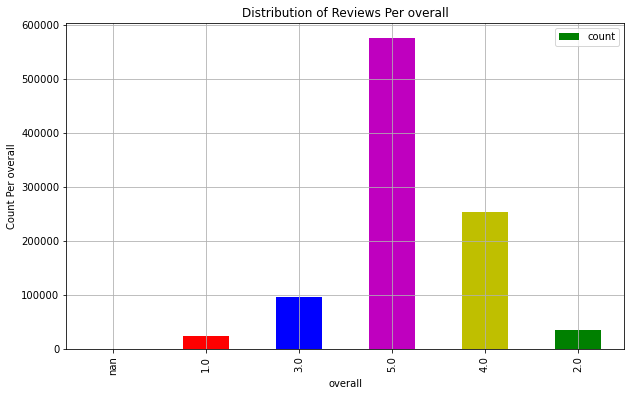

In [14]:
bar_df = kindledf_overall.toPandas()

# Create a bar chart
bar_df.plot(x='overall', y='count', kind='bar', figsize=(10,6), color=['g', 'r', 'b', 'm', 'y'])
plt.grid()
plt.xlabel("overall")
plt.ylabel("Count Per overall")
plt.title("Distribution of Reviews Per overall")

# Show the plot
plt.show()

ValueError: 'explode' must be of length 'x'

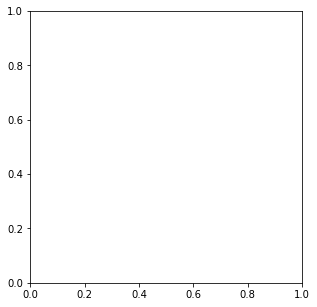

In [15]:
import pandas as pd
overall_data = bar_df["overall"]
count_data = bar_df["count"]
fig=plt.figure(figsize=(5,5))
fig.patch.set_facecolor('w')
explode = (0.1,0,0,0,0)
#Plot
plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode)
plt.title('Overall scores and their counts',bbox={'facecolor':'0.8','pad':4})
plt.legend(overall_data,loc="lower left")

In [24]:
#Creating a dataframe with the columns that will be mainly required
#amazondf = kindledf.select('overall','reviewText')
kindledf = kindledf.select('overall','reviewText')

In [25]:
kindledf.show(5)

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|      5|I enjoy vintage b...|
|      4|This book is a re...|
|      4|This was a fairly...|
|      5|I'd never read an...|
|      4|If you like perio...|
+-------+--------------------+
only showing top 5 rows



### Feature Extraction

In [26]:
#Loading packages
import pyspark.ml.feature

In [27]:
#Loading transformer and extractor packages
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer

In [28]:
#Stages for Pipeline
tokenizer = Tokenizer(inputCol='reviewText',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

In [29]:
#Score indexing
labelEncoder = StringIndexer(inputCol='overall',outputCol='label').fit(kindledf)
#amazondf = labelEncoder.transform(amazondf)RE
labelEncoder.transform(kindledf).show(5)

+-------+--------------------+-----+
|overall|          reviewText|label|
+-------+--------------------+-----+
|      5|I enjoy vintage b...|  0.0|
|      4|This book is a re...|  1.0|
|      4|This was a fairly...|  1.0|
|      5|I'd never read an...|  0.0|
|      4|If you like perio...|  1.0|
+-------+--------------------+-----+
only showing top 5 rows



In [ ]:
#amazondf.show(5)RE

In [ ]:
#scoreIndexer.labels

In [ ]:
#Dictionary of labels
#label_dict = {'1':0.0,'2':1.0,'3':2.0,'4':3.0,'5':4.0}

In [32]:
# Splitting dataset
#(trainDF,testDF) = amazondf.randomSplit([0.7,0.3],seed=42)Re
(trainDF,testDF) = kindledf.randomSplit([0.7,0.3],seed=42)

In [33]:
trainDF.show()

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|   null|                null|
|      1|"""Start at the t...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
## Estimator
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')

### Building the Pipeline

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [ ]:
pipeline

In [ ]:
pipeline.stages

In [ ]:
#Building Model
lr_model = pipeline.fit(trainDF)

In [ ]:
lr_model

In [ ]:
# Predictions on our Test Dataset
predictions = lr_model.transform(testDF)

In [ ]:
predictions.show()

In [ ]:
# Select Columns
predictions.columns

In [ ]:
predictions.select('rawPrediction','probability','subject','label','prediction').show(10)

In [ ]:
# Model Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')


In [ ]:
accuracy = evaluator.evaluate(predictions)


In [ ]:
accuracy
